In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import (
    TimeSeriesSplit,
    train_test_split,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)
from sklearn.base import clone
from prophet import Prophet

In [2]:
# Load Excel file
# Adjust sheet_name if your data is in a different sheet
df = pd.read_excel('Data.xlsx', sheet_name=1)  # 1 = second sheet

print(f"✓ Loaded {len(df)} rows from Data.xlsx")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

✓ Loaded 5623 rows from Data.xlsx

Columns: ['Date', 'Description', 'Name', 'Category', 'Credit', 'Debit', 'Balance', 'Currency']

First few rows:


,Date,Description,Name,Category,Credit,Debit,Balance,Currency
0,2025-10-27,Real Time Payment From Amazon.com 10/25 202510...,Amazon,Marketplace Payments,4685.33,NaN,34587.86,USD
1,2025-10-27,Electronic Deposit 10/27 Afterpay 1217,AfterPay,"ENTERTAINMENT_TV_AND_MOVIES, ENTERTAINMENT, GE...",2258.80,NaN,29902.53,USD
2,2025-10-27,Electronic Deposit 10/27 Shopify,NaN,Marketplace Payments,4204.92,NaN,27643.73,USD
3,2025-10-27,Real Time Payment From Amazon.com 10/26 202510...,Amazon,Marketplace Payments,5755.01,NaN,23438.81,USD
4,2025-10-27,Internet Banking Payment To Credit Line 10/25 ...,NaN,LOAN_PAYMENTS_CREDIT_CARD_PAYMENT,NaN,-3264.65,17683.80,USD


In [3]:
def load_and_preprocess_data(filepath_or_data):
    """
    Load bank transaction data from CSV, Excel, or DataFrame
    """
    if isinstance(filepath_or_data, str):
        # Check file extension
        if filepath_or_data.endswith('.xlsx') or filepath_or_data.endswith('.xls'):
            df = pd.read_excel(filepath_or_data)
        else:
            df = pd.read_csv(filepath_or_data)
    else:
        df = filepath_or_data.copy()
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.strip()
    
    # Convert date
    df['date'] = pd.to_datetime(df['date'])
    
    # Fill NaN credits/debits with 0
    df['credit'] = df['credit'].fillna(0)
    df['debit'] = df['debit'].fillna(0)
    
    # Aggregate to daily level (take end-of-day balance)
    daily_df = df.groupby('date').agg({
        'balance': 'last',
        'credit': 'sum',
        'debit': 'sum'
    }).reset_index()
    
    return daily_df

# Preprocess the data
Data = load_and_preprocess_data(df)
Data = Data.set_index('date')
Data = Data[Data.index >= "2000-01-01"]

print(f"✓ Preprocessed to {len(Data)} daily records")
print(f"  Balance range: ${Data['balance'].min():,.2f} to ${Data['balance'].max():,.2f}")
print(f"\nDaily data preview:")
Data.head()

✓ Preprocessed to 250 daily records
  Balance range: $-6,994.28 to $893,298.39

Daily data preview:


,balance,credit,debit
date,,,
2024-10-28,545510.36,33287.09,-135198.48
2024-10-29,440801.69,213247.45,-54371.47
2024-10-30,624029.58,34350.43,-66782.79
2024-10-31,568647.74,35280.15,-103999.55
2024-11-01,488661.75,108548.34,-66784.32


In [8]:
class BankTransactionForecaster:
    """
    XGBoost-based forecaster for bank transaction time series
    """
    
    def __init__(self, horizon=7, lag_features=14):
        self.horizon = horizon
        self.lag_features = lag_features
        self.model = None
        self.feature_names = []
        
    def create_time_features(self, df):
        """Create time-based features"""
        df = df.copy()
        df['day_of_week'] = df.index.dayofweek
        df['day_of_month'] = df.index.day
        df['week_of_year'] = df.index.isocalendar().week
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['is_month_start'] = df.index.is_month_start.astype(int)
        df['is_month_end'] = df.index.is_month_end.astype(int)
        df['date_offset'] = (df.index.month*100 + df.index.day - 320)%1300
        df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                              labels = ['Spring', 'Summer', 'Fall', 'Winter'])
        return df
    
    def create_lag_features(self, df, target_col='balance', n_lags=None):
        """Create lag features"""
        if n_lags is None:
            n_lags = self.lag_features
        df = df.copy()
        for lag in range(1, n_lags + 1):
            df[f'lag_{lag}'] = df[target_col].shift(lag)
        return df
    
    def create_rolling_features(self, df, target_col='balance', windows=[3, 7, 14, 30]):
        """Create rolling window statistics"""
        df = df.copy()
        for window in windows:
            df[f'rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
            df[f'rolling_std_{window}'] = df[target_col].shift(1).rolling(window=window).std()
            df[f'rolling_min_{window}'] = df[target_col].shift(1).rolling(window=window).min()
            df[f'rolling_max_{window}'] = df[target_col].shift(1).rolling(window=window).max()
        return df
    
    def create_transaction_features(self, df):
        """Create features from transaction patterns"""
        df = df.copy()
        df['daily_credits'] = df['credit']
        df['daily_debits'] = df['debit']
        df['daily_net_flow'] = df['daily_credits'] - df['daily_debits']

        
        for lag in [1, 3, 7]:
            df[f'net_flow_lag_{lag}'] = df['daily_net_flow'].shift(lag)
            df[f'credits_lag_{lag}'] = df['daily_credits'].shift(lag)
            df[f'debits_lag_{lag}'] = df['daily_debits'].shift(lag)
        return df
    
    def prepare_data(self, df, target_col='balance'):
        """Main data preparation pipeline"""
        df = df.copy()
        df = self.create_time_features(df)
        #df = self.create_transaction_features(df)
        #df = self.create_lag_features(df, target_col)
        #df = self.create_rolling_features(df, target_col)
        df_clean = df.dropna()
        return df_clean
    
    def train_test_split(self, df, test_size=0.2):
        """Time series split"""
        split_idx = int(len(df) * (1 - test_size))
        train = df.iloc[:split_idx].copy()
        test = df.iloc[split_idx:].copy()
        return train, test
    
    def fit(self, train_df, test_df, target_col='balance', xgb_params=None):
        """Train XGBoost model"""
        if xgb_params is None:
            xgb_params = {
                'objective': 'reg:squarederror',
                'max_depth': 6,
                'learning_rate': 0.1,
                'n_estimators': 100,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42
            }
        
        feature_cols = [col for col in train_df.columns 
                       if col not in [target_col, 'description', 'name', 'category']]
        self.feature_names = feature_cols
        
        X_train = train_df[feature_cols]
        y_train = train_df[target_col]
        
        X_test = test_df[feature_cols]
        y_test = test_df[target_col]
        
        self.model = xgb.XGBRegressor(**xgb_params, early_stopping_rounds = 50)
        self.model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],verbose=100)
        return self
    
    def predict(self, test_df):
        """Make predictions"""
        X_test = test_df[self.feature_names]
        return self.model.predict(X_test)
    
    def evaluate(self, test_df, target_col='balance'):
        """Evaluate model"""
        y_true = test_df[target_col].values
        y_pred = self.predict(test_df)
        
        metrics = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
        }
        return metrics, y_pred
    def cross_validate(
        self,
        df,
        target_col='balance',
        n_splits=5,
        xgb_params=None,
        test_horizon=30,
        gap=30,                 
        inner_val_frac=0.2,     # fraction of fold-train used for early stopping
        plot=True
    ):
        """
        Walk-forward / expanding-window time series cross-validation.

        - test_horizon: number of rows in each fold test set
        - gap: number of rows to leave between train and test (prevents leakage with rolling features)
        - inner_val_frac: portion of fold's training part reserved for early stopping
        """

        if xgb_params is None:
            xgb_params = {
                'objective': 'reg:squarederror',
                'max_depth': 5,
                'learning_rate': 0.05,
                'n_estimators': 1000,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42
            }

        # If user passes already-prepared data, don't prepare again.
        # Heuristic: prepared data should already have lag_1 etc.
        data = df.copy()

        EXCLUDE = {target_col, 'description', 'name', 'category'}
        feature_cols = [c for c in data.columns if c not in EXCLUDE]
        X = data[feature_cols]
        y = data[target_col]

        # TimeSeriesSplit: fixed test set length + optional gap
        tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_horizon, gap=gap)

        fold_results = []
        oof_pred = np.full(len(data), np.nan, dtype=float)

        if plot:
            fig, axs = plt.subplots(n_splits, 1, figsize=(15, 3*n_splits), sharex=True)

        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
            # ----- Inner split for early stopping (NO leakage) -----
            n_train = len(train_idx)
            cut = int((1 - inner_val_frac) * n_train)
            inner_train_idx = train_idx[:cut]
            inner_val_idx   = train_idx[cut:]

            X_tr, y_tr = X.iloc[inner_train_idx], y.iloc[inner_train_idx]
            X_val, y_val = X.iloc[inner_val_idx], y.iloc[inner_val_idx]
            X_te, y_te = X.iloc[test_idx], y.iloc[test_idx]

            model = xgb.XGBRegressor(**xgb_params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )

            y_hat = model.predict(X_te)
            oof_pred[test_idx] = y_hat

            fold_metrics = {
                "fold": fold,
                "n_train": len(inner_train_idx),
                "n_val": len(inner_val_idx),
                "n_test": len(test_idx),
                "MAE": mean_absolute_error(y_te, y_hat),
                "RMSE": float(np.sqrt(mean_squared_error(y_te, y_hat))),
                "best_iteration": getattr(model, "best_iteration", None)
            }
            fold_results.append(fold_metrics)

            if plot:
                ax = axs[fold-1] if n_splits > 1 else axs
                data[target_col].iloc[test_idx].plot(ax=ax, label="Actual (fold test)")
                pd.Series(y_hat, index=data.index[test_idx]).plot(ax=ax, label="Pred (fold test)")
                ax.axvline(data.index[test_idx].min(), color='black', ls='--')
                ax.legend(loc="upper left")

        summary = {
            "RMSE_mean": float(np.mean([r["RMSE"] for r in fold_results])),
            "RMSE_std": float(np.std([r["RMSE"] for r in fold_results])),
            "MAE_mean": float(np.mean([r["MAE"] for r in fold_results])),
            "MAE_std": float(np.std([r["MAE"] for r in fold_results])),
        }

        print("CV summary:", summary)
        print("Fold metrics:")
        for r in fold_results:
            print(r)

        if plot:
            plt.show()

        return fold_results, summary, pd.Series(oof_pred, index=data.index, name="oof_pred")
        
        


print("✓ BankTransactionForecaster class defined")

✓ BankTransactionForecaster class defined


<Axes: xlabel='day_of_week', ylabel='balance'>

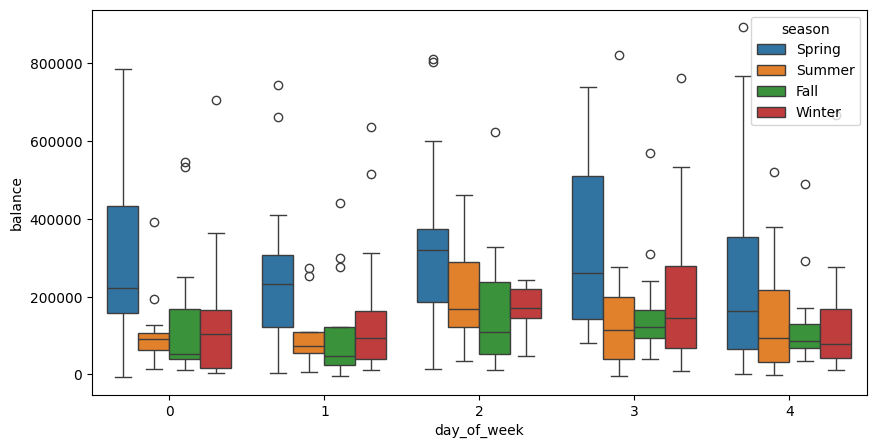

In [11]:
forecaster = BankTransactionForecaster(lag_features=14)


# Create features
Data_prepared = forecaster.prepare_data(Data, target_col='balance')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data = Data_prepared, x = "day_of_week", y = "balance", hue = 'season',
            ax = ax, linewidth = 1)

In [ ]:
train, test = forecaster.train_test_split(Data_prepared, test_size=0.2)
#Prophet model requires the datetime column to be named ds
#target must be y

balance_train_prophet = train.reset_index().rename(columns = {'date':'ds',
                                                              'balance': 'y'})


,ds,y,credit,debit,day_of_week,day_of_month,week_of_year,month,quarter,is_weekend,is_month_start,is_month_end,date_offset,season
0,2024-10-28,545510.36,33287.09,-135198.48,0,28,44,10,4,0,0,0,708,Fall
1,2024-10-29,440801.69,213247.45,-54371.47,1,29,44,10,4,0,0,0,709,Fall
2,2024-10-30,624029.58,34350.43,-66782.79,2,30,44,10,4,0,0,0,710,Fall
3,2024-10-31,568647.74,35280.15,-103999.55,3,31,44,10,4,0,0,1,711,Fall
4,2024-11-01,488661.75,108548.34,-66784.32,4,1,44,11,4,0,1,0,781,Fall


In [18]:

model = Prophet()
model.fit(balance_train_prophet)

16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
balance_test_prophet = test.reset_index().rename(columns = {'date':'ds',
                                                              'balance': 'y'})

balance_test_fcst = model.predict(balance_test_prophet)
balance_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2025-08-15,213307.123635,-141454.678568,411080.691742,213307.123635,213307.123635,-68929.354358,-68929.354358,-68929.354358,-68929.354358,-68929.354358,-68929.354358,0.0,0.0,0.0,144377.769278
1,2025-08-18,212281.448930,-101071.271929,400428.122020,212280.166508,212282.102251,-50821.904512,-50821.904512,-50821.904512,-50821.904512,-50821.904512,-50821.904512,0.0,0.0,0.0,161459.544418
2,2025-08-19,211939.557361,-130970.587638,390486.943653,211935.726183,211942.199325,-77187.831407,-77187.831407,-77187.831407,-77187.831407,-77187.831407,-77187.831407,0.0,0.0,0.0,134751.725954
3,2025-08-20,211597.665792,-66575.775068,466127.514534,211590.714709,211603.474368,-17871.506215,-17871.506215,-17871.506215,-17871.506215,-17871.506215,-17871.506215,0.0,0.0,0.0,193726.159578
4,2025-08-21,211255.774224,-87209.041944,442622.363633,211245.003392,211266.726800,-31334.359834,-31334.359834,-31334.359834,-31334.359834,-31334.359834,-31334.359834,0.0,0.0,0.0,179921.414389


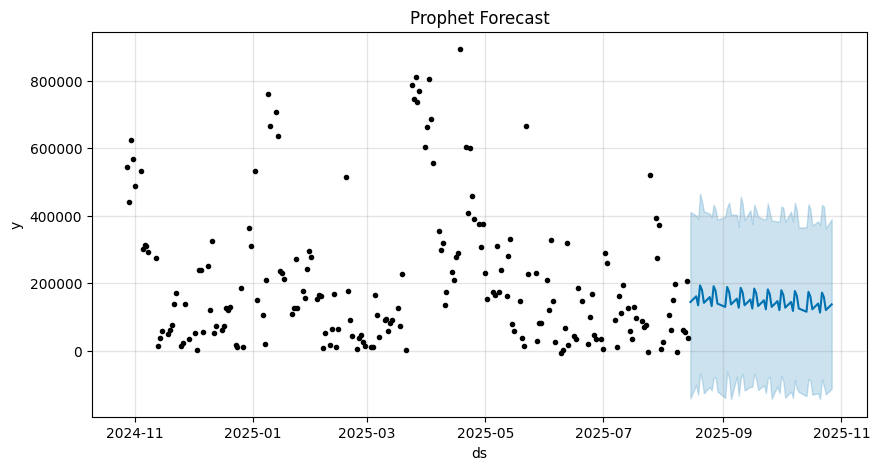

In [23]:
fig, ax = plt.subplots(figsize = (10,5))
fig = model.plot(balance_test_fcst, ax = ax)
ax.set_title('Prophet Forecast')
plt.show()

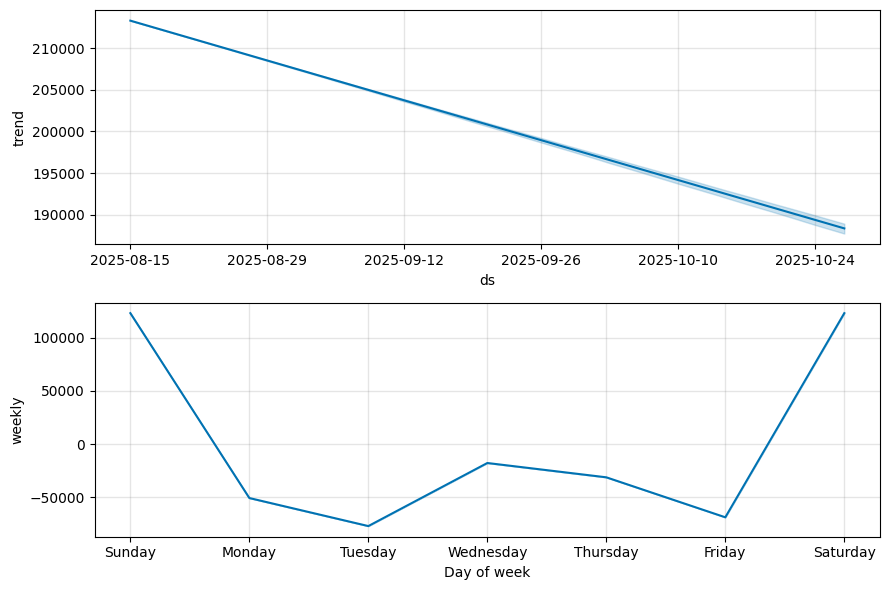

In [24]:
fig = model.plot_components(balance_test_fcst)
plt.show()

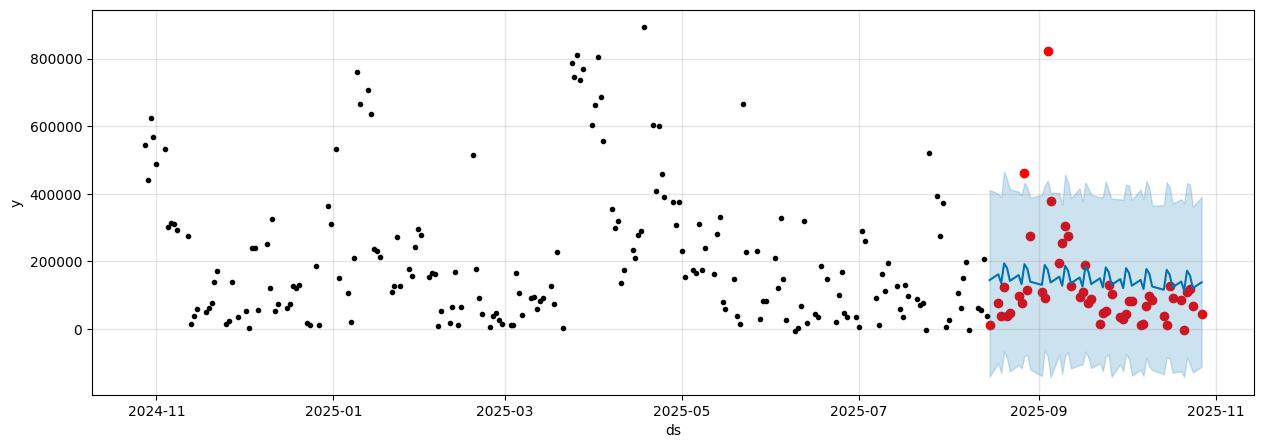

In [25]:
fig, ax = plt.subplots(figsize = (15,5))
ax.scatter(test.index, test['balance'], color = "r")
fig = model.plot(balance_test_fcst, ax = ax)
plt.show()

In [26]:
np.sqrt(mean_squared_error(y_true = test['balance'], y_pred = balance_test_fcst['yhat']))

135857.34780709166

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calender

cal = calender()

holidays = cal.holidays(start = Data_prepared.index.min(), end = Data_prepared.index.max())

holiday_df = pd.DataFrame({
    "holiday_name": "USFederalHoliday"
}, index=holidays)

In [33]:
holiday_df['holiday_name'].value_counts()
holiday_df.head()

,holiday_name
2024-11-11,USFederalHoliday
2024-11-28,USFederalHoliday
2024-12-25,USFederalHoliday
2025-01-01,USFederalHoliday
2025-01-20,USFederalHoliday


In [35]:
future = model.make_future_dataframe(periods = 365, include_history=False)
forecast = model.predict(future)